**Zero-shot classification using Natural Language Inference**

As shown in Figure below, the
overall idea of ZSL is to convert a text classification problem into a natural language inference
(NLI) problem.

NLI is the task of determining
whether, given a premise, a hypothesis is true (entailment) or false (contradiction) or neither (neutral). We typically treat
the text to be classified (i.e., legal questions) as
the premise, and construct the hypothesis from the
class name of the label, “Cette question concerne la catégorie {label},”
where “{label}” would be the category.

If the NLI model tells us that the premise
is likely to entail the hypothesis, we can conclude
that the label is associated with the input legal question and vice versa and therefore we are implicitely classifying the legal quetions into their categories.

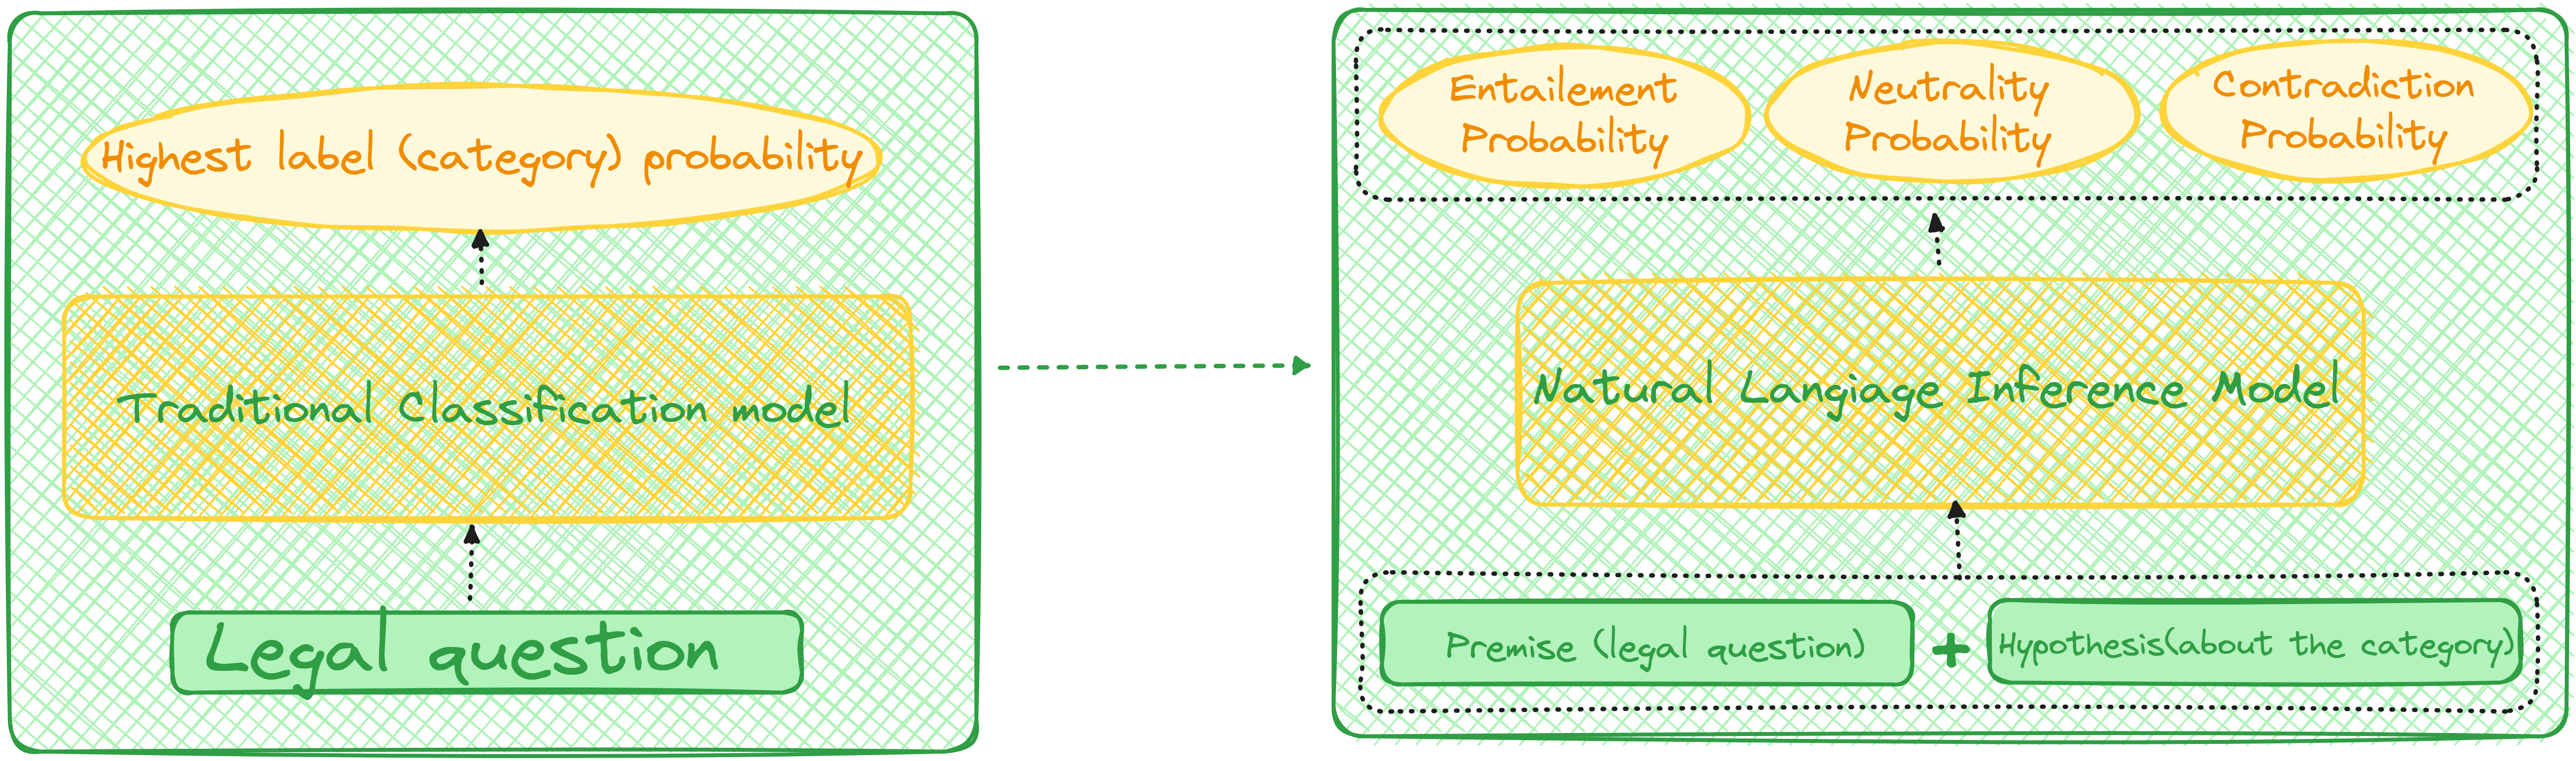

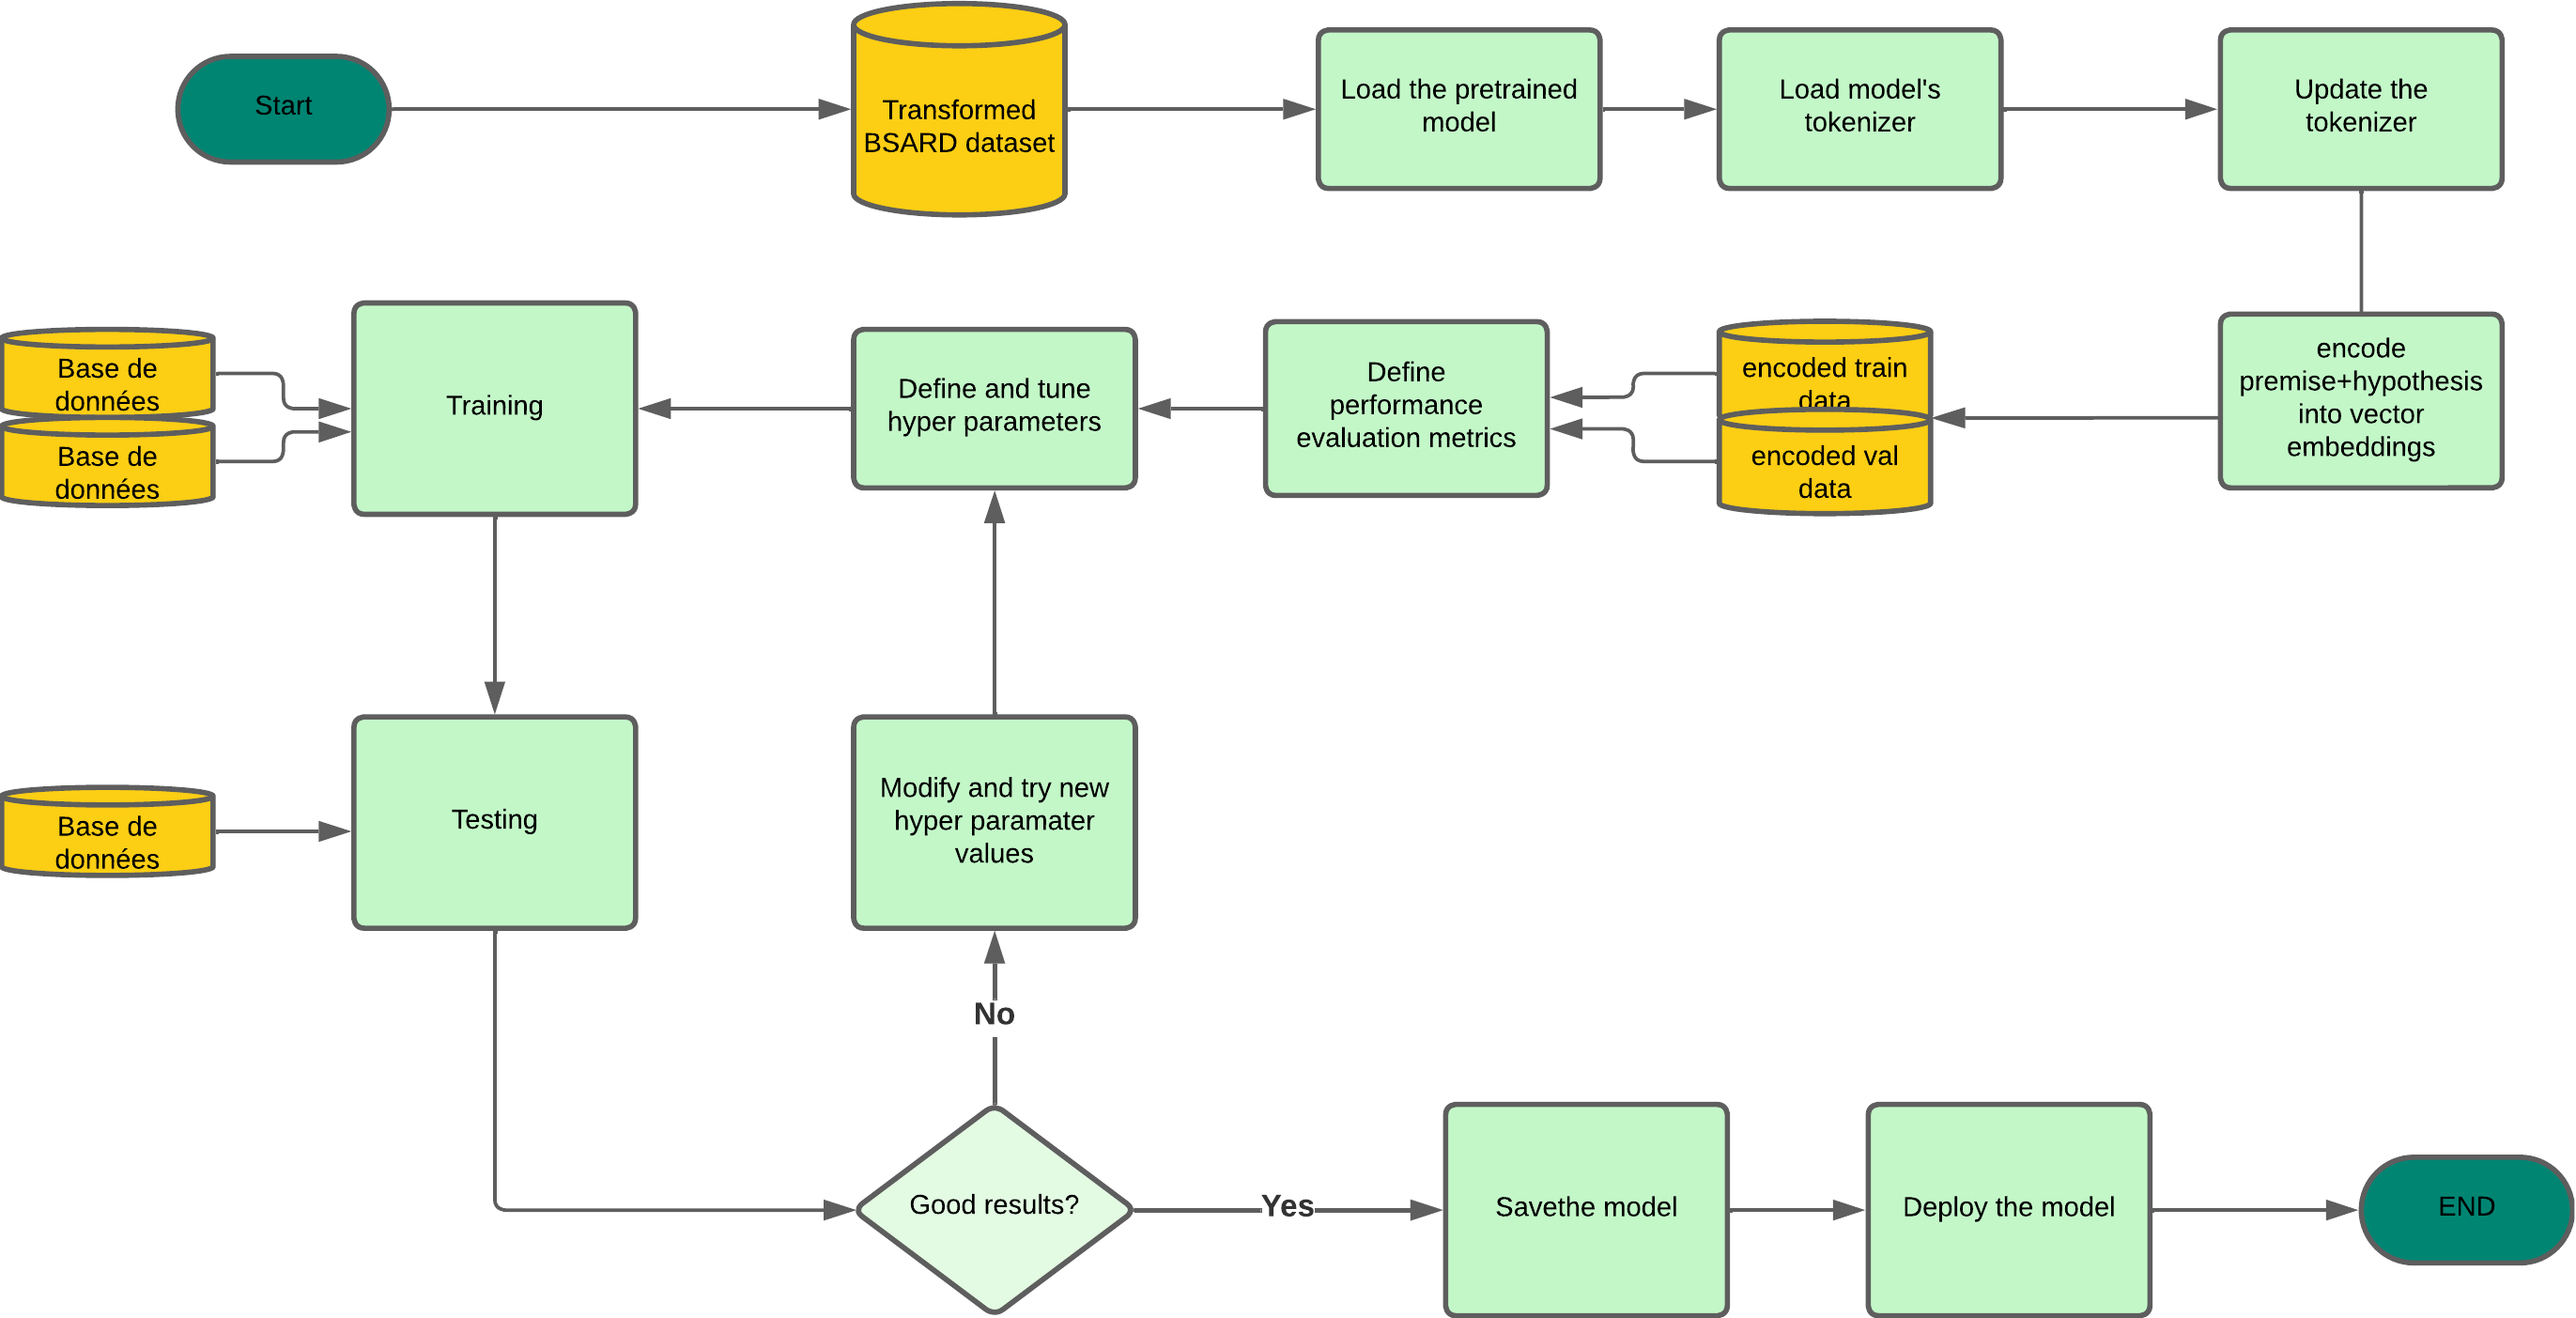

# **Installing necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers torch==2.1.0 pandas datasets numpy matplotlib keras scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [4]:
!pip install git+https://github.com/huggingface/accelerate.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install bitsandbytes

  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-318u99jx
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-318u99jx
  Resolved https://github.com/huggingface/accelerate.git to commit 10882eeddd841b0a1a8064421816ee0daef99920
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.28.0.dev0-py3-none-any.whl size=289247 sha256=1bef4b01d4c50a7850b09c5b5da21440ea58b9a07ae47fc0d22e29176403dbe2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vkp3kmtr/wheels/9c/a3/1e/47368f9b6575655fe9ee1b6350cfa7d4b0befe66a35f8a8365
Successfully built accelerate
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-m78fcm5k
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-m78fcm5k


In [5]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 4.4 MB/s eta 0:00:00


# **Pre step**: Imports

In [6]:
from datasets import Dataset,load_metric
from transformers import AutoModel,AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments ,EvalPrediction,DataCollatorWithPadding, EarlyStoppingCallback, BitsAndBytesConfig
import numpy as np
from itertools import chain
import re
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.model_selection import train_test_split
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig

**Making sure our GPU is available and active**

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have only one GPU
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU instead.")

device = torch.device("cuda:0")

GPU is available
GPU Device Name: Tesla T4


# **Model selection**:
For this we can simply look for models that have been pretrained for NLI tasks on either french texts or multilingual texts including french:


*   **camemBERT** : "CamemBERT is a state-of-the-art language model for French based on the RoBERTa architecture pretrained on the French subcorpus of the newly available multilingual corpus OSCAR.
We evaluate CamemBERT in four different downstream tasks for French: part-of-speech (POS) tagging, dependency parsing, named entity recognition (NER) and natural language inference (NLI)" [Model's official website](https://camembert-model.fr/)
*   **DistilCamemBERT** : istillation version of the well named CamemBERT, a RoBERTa French model version, alias DistilCamemBERT. The aim of distillation is to drastically reduce the complexity of the model while preserving the performances. The proof of concept is shown in the DistilBERT paper and the code used for the training is inspired by the code of DistilBERT.

*  **mDeBERTa V3** : DeBERTa improves the BERT and RoBERTa models using disentangled attention and enhanced mask decoder. With those two improvements, DeBERTa out perform RoBERTa on a majority of NLU tasks with 80GB training data.



In [8]:
# Clear CUDA cache (if applicable)
torch.cuda.empty_cache()

#for quantization
config = BitsAndBytesConfig(
    load_in_8bit=True,
    #bnb_4bit_quant_type="nf4",
    #bnb_4bit_use_double_quant=True,
    #bnb_4bit_compute_dtype=torch.bfloat16,
)


# Load the model and tokenizer directly
model_name = "cmarkea/distilcamembert-base-nli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)#, load_in_4bit=True
#model = AutoModelForSequenceClassification.from_pretrained(model_name, load_in_4bit=True, task="SEQ_CLS", architecture="bart-large-mnli")
#model = prepare_model_for_kbit_training(model)
#for qeft
config = LoraConfig(
    r=16,
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["model.encoder.layers.*.self_attn", "model.decoder.layers.*.self_attn"],
)
#model = get_peft_model(model, config)
# Specify device (GPU or CPU)
model.to(device)  # Move model to the specified device

# Define task
task = "zero-shot-classification"

# Output directory
output_dir = "/legal-data-distilledCamemBERT"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/272M [00:00<?, ?B/s]

In [9]:
print(model.config)

CamembertConfig {
  "_name_or_path": "cmarkea/distilcamembert-base-nli",
  "architectures": [
    "CamembertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.39.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}



In [10]:
df = pd.read_csv("/content/new_data_train.csv")
dft = pd.read_csv("/content/new_data_test.csv")

**Updating the tokenizer** :

we have to prepare our new tokens for the tokenizer. This step is crucial to ensure that our tokenizer can effectively tokenize most of the specialized vocabulary in our new domain.

In [11]:
# Retrieve the keys (tokens/words) from the tokenizer's vocabulary
vocabulary = tokenizer.get_vocab().keys()

def get_new_tokens(sentences, vocabulary):
    # Create a set for faster lookup
    vocab_set = set(vocabulary)

    # Generator expression to yield words without ".", whitespace characters, or newline characters along with the pattern " 's "
    # You may use different cleaning methods in various languages
    cleaned_words = (re.sub(r"[.'\s\n]+|('\s)", "", word).lower().strip() for sentence in sentences for word in sentence.split())

    # Yield words that are not in the vocabulary set and are not empty
    return [word for word in cleaned_words if word not in vocab_set and word]

In [12]:
# Define a function to count the occurrences of words in a list
def word_count(word_list):
  return Counter(word_list)

In [13]:
# Get the 'hypothesis' column values as a list and concatenate with 'premise' column values as a list
sentences = df['hypothèse'].to_list() + df['premisse'].to_list()

In our case, let's consider words that appeared more than 10 times in our dataset

In [14]:
# Function to get new tokens from sentences that are not in the existing vocabulary
tokens_to_add = get_new_tokens(sentences,vocabulary)

# Count the occurrences of these new tokens
words = word_count(tokens_to_add)

# Initialize an empty list to store new tokens
new_tokens = []

# Loop through the words and their counts
for key,value in words.items():
  # Check if the count of the word is greater than 10 and if the length of the word is greater than 2
  if value > 10 and len(key)>2:
    # If conditions are met, add the word to the list of new tokens
    new_tokens.append(key)

In [15]:
new_tokens

['question',
 'concerne',
 'catégorie',
 'logement',
 'etrangers',
 'justice',
 'sociale',
 'marié(e)',
 'sommes',
 'mariés',
 'dois-je',
 'quels',
 'est-il',
 'wallonie',
 'bruxelles',
 'parent',
 'payer',
 'contribution',
 'nai',
 'bail',
 'puis-je',
 'recours',
 'décision',
 'd’un',
 'jai',
 'signé',
 'déclaration',
 'cohabitation',
 'légale',
 'dettes',
 'cohabitant',
 'légal',
 'cause',
 'désunion',
 'irrémédiable',
 'montant',
 'peut-il',
 'colocation',
 'sont',
 'lenfant',
 'quelquun',
 'peut-on',
 'réclamer',
 'conjoint',
 'est-elle',
 'collectif',
 'sépare',
 'procédure',
 'mesures',
 'urgentes',
 'provisoires',
 'cohabitants',
 'daccord',
 'mineur',
 'quelles',
 'conditions',
 'biens',
 'et/ou',
 'démarches',
 'loyer',
 'mexpulser',
 'demander',
 'tribunal',
 'divorce',
 'paie',
 'refuser',
 'quest-ce',
 'marier',
 'meubles',
 'divorcer',
 'd’une',
 'contester',
 'récupérer',
 'garantie',
 'locative',
 'reprendre',
 'passe-t-il',
 'd’accord',
 'dune',
 'règlement',
 'victime'

Let's add the new tokens to our tokenizer

In [16]:
# Add new_tokens to the tokenizer's vocabulary
tokenizer.add_tokens(new_tokens)

# Resize the model's token embeddings to match the updated tokenizer's vocabulary size
model.resize_token_embeddings(len(tokenizer))

Embedding(32147, 768)

Let's define a function to shuffle our data to prevent our model from memorizing the dataset’s order, which is crucial for robust learning.

In [17]:
# Perform shuffling
def shuffle_df(old_df: pd.DataFrame, cycles: int = 1) -> pd.DataFrame:
    np.random.seed(42)  # Set a random seed for reproducibility
    for i in range(cycles):
        # Shuffle the rows of the DataFrame
        new_df = old_df.sample(frac=1).reset_index(drop=True)
        return new_df

**Creating input sentences for our model**

In [18]:
def create_input_sequence(sample):
  # Get text from the 'premise' column
  text = sample["premisse"]

  # Get hypothesis from the 'hypothesis' column
  hypothesis = sample['hypothèse']

  # Get label from the 'class' column
  label = sample['label']

  # Encoding the sequence using the tokenizer
  encoded_sequence = tokenizer(text, hypothesis, truncation=True, padding='max_length')

  # Assign label to the encoded sequence
  encoded_sequence['labels'] = label

  # Decode the input_ids
  encoded_sequence["input_sentence"] = tokenizer.batch_decode(encoded_sequence.input_ids)

  return encoded_sequence

In [19]:
# Shuffle the train_data DataFrame and create a new DataFrame with shuffled rows
train_shuffle_df = shuffle_df(df)

# Shuffle the test_data DataFrame and create a new DataFrame with shuffled rows
test_shuffle_df = shuffle_df(dft)

# Create a Dataset object from the shuffled train DataFrame
train = Dataset.from_pandas(train_shuffle_df)

# Create a Dataset object from the shuffled test DataFrame
test = Dataset.from_pandas(test_shuffle_df)

# Map the create_input_sequence function to the train and test datasets
# This function encodes the data, adds labels, and generates input sentences
train_dataset = train.map(create_input_sequence,batched=True,batch_size=1,remove_columns=["label","premisse"])
test_dataset = test.map(create_input_sequence,batched=True,batch_size=1,remove_columns=["label","premisse"])

Map:   0%|          | 0/1156 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

In [20]:
train_dataset

Dataset({
    features: ['Unnamed: 0', 'hypothèse', 'input_ids', 'attention_mask', 'labels', 'input_sentence'],
    num_rows: 1156
})

# **Taining**:
Let's keep in mind that our model is not getting trained from scratch it will be based on the original pre-trained model and we are just fine-tuning it with our task-specific dataset.

We will create a function to evaluate the model performance, that will be an argument in our trainer.

In [21]:
def compute_metrics(p: EvalPrediction):
  # Extracting predictions from EvalPrediction object
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  # Obtaining the predicted classes
  preds = np.argmax(preds, axis = 1)

  # Calculating the ratio of predictions equal to 2 (assumed label)
  ratio = np.mean(preds == 2)

  # Dictionary to store computed metrics
  result = {}

  # Loading evaluation metrics
  metric_f1 = load_metric("f1")
  metric_precision = load_metric("precision")
  metric_recall = load_metric("recall")
  metric_acc = load_metric("accuracy")

  # Computing various metrics
  result["accuracy"] = metric_acc.compute(predictions = preds, references = p.label_ids)["accuracy"]
  result["precision"] = metric_precision.compute(predictions = preds, references = p.label_ids,average = 'macro')['precision']
  result["recall"] = metric_recall.compute(predictions = preds, references = p.label_ids,average = 'macro')["recall"]
  result["f1"] = metric_f1.compute(predictions = preds, references = p.label_ids, average = 'macro')["f1"]
  result["ratio"] = ratio

  return result

Defining the training arguments ie. the model's hyper-parameters:

In [22]:
training_args = TrainingArguments(
  output_dir=output_dir,           # Output directory
  logging_dir=output_dir + "/logs",# Output directory for logging
  num_train_epochs=15,              # Total number of training epochs
  per_device_train_batch_size=16,  # Batch size per device during training
  per_device_eval_batch_size=16,    # Batch size for evaluation
  warmup_steps=4,                  # Number of warmup steps for learning rate scheduler
  weight_decay=0.1,               # Strength of weight decay
  gradient_accumulation_steps=1,   # The number of steps whose gradients are accumulated
  learning_rate=2e-05,             # Controls the magnitude of updates to the model weights
  warmup_ratio=0.1,               # Represents the proportion of training steps
  label_smoothing_factor=0.1,      # Regularization technique to prevent the model from becoming overconfident
  evaluation_strategy='steps',     # Frequency or timing of evaluating
  logging_strategy='steps',        # Frequency or timing of logging
  logging_steps = 10,              # Frequency or timing of logging
  eval_steps = 10,                 # Frequency or timing of evaluating
  logging_first_step=True,
  do_eval=True,
  metric_for_best_model="f1",
  load_best_model_at_end=True
)

**Early stopping**: Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [23]:
early_stopping_callback = EarlyStoppingCallback(3, 1.0)

trainer = Trainer(
  model=model,                     # The instantiated model to be trained
  args=training_args,              # Training arguments, defined above
  compute_metrics=compute_metrics, # A function to compute the metrics
  train_dataset=train_dataset,     # Training dataset
  eval_dataset=test_dataset,        # Evaluation dataset
  callbacks=[early_stopping_callback]

)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
trainer.evaluate()

<ipython-input-21-4fa53b31c593>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_f1 = load_metric("f1")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 1.5626118183135986,
 'eval_accuracy': 0.32974910394265233,
 'eval_precision': 0.28325269501740086,
 'eval_recall': 0.3290627621444368,
 'eval_f1': 0.2460133744855967,
 'eval_ratio': 0.05017921146953405,
 'eval_runtime': 7.8544,
 'eval_samples_per_second': 35.521,
 'eval_steps_per_second': 2.292}

In [25]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next m

TrainOutput(global_step=530, training_loss=0.7662905506367953, metrics={'train_runtime': 716.8702, 'train_samples_per_second': 24.188, 'train_steps_per_second': 1.527, 'total_flos': 1112216113557504.0, 'train_loss': 0.7662905506367953, 'epoch': 7.26})

In [26]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next m

{'eval_loss': 0.8276138305664062,
 'eval_accuracy': 0.7526881720430108,
 'eval_precision': 0.7810867293625914,
 'eval_recall': 0.7522571361310879,
 'eval_f1': 0.7428753019636334,
 'eval_ratio': 0.27956989247311825,
 'eval_runtime': 6.1352,
 'eval_samples_per_second': 45.475,
 'eval_steps_per_second': 2.934,
 'epoch': 7.26}

In [ ]:
model.eval()

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32147, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-5): 6 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

# **Visualizing performance metrics**:

In [27]:
import plotly.graph_objects as go

data = """
Step	TrainingLoss	ValidationLoss	Accuracy	Precision	Recall	F1	Ratio
10	1.274400	0.883617	0.584229	0.626648	0.585315	0.599701	0.250896
20	1.003800	0.736679	0.666667	0.677445	0.669869	0.602738	0.326165
30	0.807500	0.648708	0.691756	0.693649	0.693167	0.691916	0.329749
40	0.990000	0.693068	0.688172	0.701971	0.690841	0.663846	0.329749
50	0.921800	0.656273	0.763441	0.765485	0.764852	0.764376	0.329749
60	0.825300	0.656101	0.752688	0.772069	0.753260	0.742216	0.329749
70	0.900200	0.666934	0.738351	0.748430	0.739152	0.731900	0.329749
80	0.845000	0.693560	0.716846	0.749790	0.719439	0.690615	0.329749
90	0.845400	0.694283	0.770609	0.818799	0.770838	0.751907	0.329749
100	0.842300	0.638120	0.756272	0.771142	0.756921	0.748775	0.329749
110	0.794300	0.672179	0.720430	0.722428	0.721727	0.720960	0.329749
120	0.816800	0.645792	0.741935	0.751792	0.742736	0.736062	0.329749
130	0.777600	0.727972	0.741935	0.751792	0.742736	0.736062	0.329749
140	0.775200	0.676208	0.741935	0.751792	0.742736	0.736062	0.329749
150	0.756200	0.691109	0.749104	0.761254	0.749828	0.742424	0.329749
160	0.757400	0.714433	0.741935	0.751792	0.742736	0.736062	0.329749
170	0.786000	0.661111	0.741935	0.751792	0.742736	0.736062	0.329749
180	0.764000	0.714074	0.777778	0.829213	0.777968	0.759660	0.329749
190	0.784200	0.761247	0.706093	0.707986	0.707466	0.706650	0.329749
200	0.823300	0.782213	0.573477	0.638240	0.574063	0.593564	0.225806
210	0.764700	0.669567	0.788530	0.822579	0.788836	0.777334	0.329749
220	0.720500	0.687144	0.702509	0.704198	0.703958	0.703557	0.329749
230	0.764800	0.713797	0.716846	0.719198	0.718104	0.716773	0.329749
240	0.697500	0.736824	0.749104	0.761254	0.749828	0.742424	0.329749
250	0.707600	0.739483	0.784946	0.809596	0.785366	0.776369	0.329749
260	0.764800	0.756217	0.731183	0.739248	0.732134	0.731011	0.322581
270	0.739600	0.722391	0.770609	0.783709	0.771258	0.765389	0.329749
280	0.719100	0.732714	0.777778	0.793694	0.778350	0.771861	0.329749
290	0.701200	0.737939	0.767025	0.778879	0.767711	0.762149	0.329749
300	0.748000	0.726925	0.792115	0.833637	0.792343	0.779284	0.329749
310	0.647500	0.780588	0.774194	0.856250	0.774232	0.747663	0.329749
320	0.721100	0.756759	0.720430	0.722688	0.721688	0.720575	0.329749
330	0.714300	0.750613	0.745520	0.750140	0.746511	0.743952	0.329749
340	0.743400	0.751026	0.781362	0.809972	0.781743	0.770978	0.329749
350	0.748900	0.739674	0.695341	0.696949	0.696942	0.696935	0.329749
360	0.711800	0.755854	0.781362	0.801256	0.781858	0.774161	0.329749
370	0.754000	0.835138	0.784946	0.828795	0.785175	0.770327	0.329749
380	0.691700	0.784560	0.781362	0.794715	0.781972	0.776786	0.329749
390	0.685300	0.764330	0.770609	0.780473	0.771334	0.766978	0.329749
400	0.652000	0.762877	0.752688	0.757594	0.753641	0.751164	0.329749
410	0.649200	0.757029	0.781362	0.806785	0.781781	0.772104	0.329749
420	0.720300	0.719063	0.767025	0.780602	0.767673	0.761281	0.329749
430	0.730000	0.743988	0.749104	0.753492	0.750095	0.747843	0.329749
440	0.743600	0.816880	0.795699	0.824144	0.796042	0.787048	0.329749
450	0.689700	0.781224	0.788530	0.802634	0.789102	0.784105	0.329749
460	0.676200	0.774585	0.777778	0.788226	0.778464	0.774260	0.329749
470	0.665500	0.755970	0.781362	0.794715	0.781972	0.776786	0.329749
480	0.633000	0.761048	0.691756	0.693396	0.693396	0.693396	0.329749
490	0.697800	0.751706	0.788530	0.812386	0.788950	0.780602	0.329749
500	0.746800	0.818080	0.749104	0.777093	0.748634	0.739550	0.275986
510	0.778300	0.779383	0.774194	0.788123	0.774649	0.770657	0.318996
520	0.663000	0.771537	0.749104	0.754266	0.750057	0.747258	0.329749
530	0.699400	0.754972	0.759857	0.768207	0.760657	0.756432	0.329749

"""

# Splitting the data by lines and extracting header and values
lines = data.strip().split('\n')
header = lines[0].split()
values = [line.split() for line in lines[1:]]

# Creating dictionary
training_evolution = {metric: [] for metric in header}

# Populating the dictionary with values
for row in values:
    for i, metric in enumerate(header):
        training_evolution[metric].append(float(row[min(i, len(row)-1)]))

print(training_evolution)

{'Step': [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0], 'TrainingLoss': [1.2744, 1.0038, 0.8075, 0.99, 0.9218, 0.8253, 0.9002, 0.845, 0.8454, 0.8423, 0.7943, 0.8168, 0.7776, 0.7752, 0.7562, 0.7574, 0.786, 0.764, 0.7842, 0.8233, 0.7647, 0.7205, 0.7648, 0.6975, 0.7076, 0.7648, 0.7396, 0.7191, 0.7012, 0.748, 0.6475, 0.7211, 0.7143, 0.7434, 0.7489, 0.7118, 0.754, 0.6917, 0.6853, 0.652, 0.6492, 0.7203, 0.73, 0.7436, 0.6897, 0.6762, 0.6655, 0.633, 0.6978, 0.7468, 0.7783, 0.663, 0.6994], 'ValidationLoss': [0.883617, 0.736679, 0.648708, 0.693068, 0.656273, 0.656101, 0.666934, 0.69356, 0.694283, 0.63812, 0.672179, 0.645792, 0.727972, 0.676208, 0.691109, 0.714433, 0.661111, 0.714074, 

**Training and Loss evolution through epochs**

In [28]:
import plotly.graph_objects as go

# Plotting training and validation loss
fig = go.Figure()

fig.add_trace(go.Scatter(x=training_evolution['Step'], y=training_evolution['TrainingLoss'],
                         mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=training_evolution['Step'], y=training_evolution['ValidationLoss'],
                         mode='lines+markers', name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Step',
                  yaxis_title='Loss')

fig.show()


**Accuracy and F1-score Evolution**

In [29]:
import plotly.graph_objects as go

# Plotting training and validation loss
fig = go.Figure()

fig.add_trace(go.Scatter(x=training_evolution['Step'], y=training_evolution['Accuracy'],
                         mode='lines+markers', name='Accuracy'))
fig.add_trace(go.Scatter(x=training_evolution['Step'], y=training_evolution['F1'],
                         mode='lines+markers', name='F1 score'))

fig.update_layout(title='Accuracy and F1 score evolution thoughout training',
                  xaxis_title='Step',
                  yaxis_title='Score')

fig.show()

# **Using the model for NLI**:

In [30]:
# Define candidate labels (adjust to your task)
candidate_labels_NLI = ["entailment", "neutral", "contradiction"]

# Function to perform zero-shot classification
def NLI(text, hypothesis):
    # Preprocess with tokenization
    inputs = tokenizer(text, hypothesis, return_tensors="pt")

    # Move to device (if specified)
    inputs = inputs.to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)

    # Get logits and predicted label
    logits = outputs.logits
    predicted_index = logits.argmax(axis=-1).item()
    predicted_label = candidate_labels_NLI[predicted_index]

    return predicted_label

In [31]:
p = NLI("Peut-on m'expulser en été en Wallonie ?", "cette question ne concerne pas la catégorie Logement")
print(p)

contradiction


# **Zero-shot classification using NLI**:

In [32]:
def zero_shot_classify(model, tokenizer, text, candidate_labels):

    # Initialize list to store entailment probabilities for each class
    entailment_probs = []

    # Loop through each candidate label
    for label in candidate_labels:
        # Create hypothesis for the current label
        hypothesis = f"cette question concerne la catégorie {label}."

        # Tokenize input text and hypothesis
        inputs = tokenizer(text, hypothesis, return_tensors="pt")
        inputs = inputs.to(model.device)
        outputs = model(**inputs)

        # Get logits and entailment probability
        logits = outputs.logits
        entailment_prob = torch.softmax(logits, dim=1)[0][0].item()  # Probability of entailment (0 is entailment class)

        # Append entailment probability to the list
        entailment_probs.append((label, entailment_prob))

    # Sort entailment probabilities in descending order
    entailment_probs = sorted(entailment_probs, key=lambda x: x[1], reverse=True)

    return entailment_probs

# Example usage
text = "Je suis parent. Dois-je encore payer une contribution alimentaire si je n'ai plus de contact avec mes enfants ?"
candidate_labels_zeroshot = ["Logement", "Family", "Argent", "Travail", "Protection sociale", "Etrangers", "Justice"]
results = zero_shot_classify(model, tokenizer, text, candidate_labels_zeroshot)
print("Entailment Probabilities:")
for label, prob in results:
    print(f"{label}: {prob:.4f}")

Entailment Probabilities:
Family: 0.8661
Protection sociale: 0.4312
Logement: 0.3604
Travail: 0.3184
Etrangers: 0.2898
Justice: 0.0604
Argent: 0.0532


# **Model Inference**:
For inference i decided to use the Gradio library since it is easy to implement.

In [33]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl s

In [34]:
import gradio as gr


In [36]:
import gradio as gr

def inference(text, hypothesis):
  answer = NLI(text, hypothesis)
  probs = zero_shot_classify(model, tokenizer, text, candidate_labels_zeroshot)

  output_inference = f"**NLI:**\n{answer}"
  output_classification = f"**Zero-shot Classification:**\n"
  for label, prob in probs:
    output_classification += f"- {label}: {prob:.4f}\n"

  return output_inference, output_classification

css = """
.gradio-container {
  background-color: #e0f2f1; /* Light blue background */
  color: #333; /* Dark text for better contrast */
}

.gradio-components {
  border-radius: 5px; /* Rounded corners for components */
  border: 1px solid #c2dfe3; /* Lighter pistachio green border */
  background-color: #d7eee8; /* Slightly lighter pistachio green background */
}

.gradio-Textbox input {
  background-color: #f5f9f7; /* Light gray background for input */
  color: #333; /* Dark text for input */
  border: 1px solid #c2dfe3; /* Lighter pistachio green border */
  padding: 10px; /* Add padding for better spacing */
}

.gradio-Button {
  background-color: #93c59b; /* Darker pistachio green background */
  color: #fff; /* White text for button */
  border: none; /* Remove border for cleaner look */
  border-radius: 5px; /* Rounded corners for button */
  padding: 10px 20px; /* Add padding for improved button size */
  font-weight: bold; /* Make button text bold */
}

.gradio-Textbox[label="Inférence"], .gradio-Textbox[label="Classification"] {
  font-weight: bold; /* Bold text for labels */
  padding: 10px; /* Add padding to output areas */
  background-color: #f5f9f7; /* Light gray background for outputs */
}
.gradio-title {
  text-align: center;}
"""
interface = gr.Interface(
  title="NLI and Zeroshot Classification of Belgian legal questions",
  css=css,
  fn=inference,
  inputs=[
      gr.Textbox(show_label=False, placeholder="Entrez votre texte ici..."),
      gr.Textbox(show_label=False, placeholder="Entrez votre hypothèse ici...")
  ],
  outputs=[
     gr.Textbox(label="Inférence"),
     gr.Textbox(label="Classification"),
  ],
  examples=[
      ["Peut-on m'expulser en été en Wallonie ?", "Cette question concern la catégorie Logement"],
      ["Peut-on m'expulser en été en Wallonie ?", "Cette question ne concern pas la catégorie Logement"],
      ["Je suis parent. Dois-je encore payer une contribution alimentaire si je n'ai plus de contact avec mes enfants ?", "Cette question concerne la catégorie Famille"],
      ["Je suis parent. Dois-je encore payer une contribution alimentaire si je n'ai plus de contact avec mes enfants ?", "Cette question ne concerne pas la catégorie Famille"]

      ]
)

interface.launch(inbrowser=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://222d807f66da4c8c8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
